<h1 align="center">An Introduction to Machine Learning - 25737</h1>
<h4 align="center">Dr. Yassaee</h4>
<h4 align="center">Sharif University of Technology, Autumn 2024</h4>

**Student Name**: Arian Bastani

**Student ID**: 400100073

# Non-Linear Classification with SVM

## 1. DATA SET AND VISUALIZATION FUNCTION
We will use the non-linear toy data called the Moon dataset. You may use the code snippet below to generate the train/test set. Feel free to change the number of samples, and noise level. Additionally, a function plot_svm() is provided to help you visualize the decision boundary, margin, and support vectors on the dataset in 2D feature space.

The provided function plot_svm() works out-the-box, and is the best way to visualize and evaluate the performance of your model. It assumes the classifier has an instance variable "self.support_vectors_", which is a numpy array of the support vectors found in training. DO NOT modify this function. Once your implementation in Task 3 is complete, the plots generated for your model should look similar to the plots generated for the standard library models in Task 2.

In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from scipy.stats import randint, uniform
import numpy as np
import cvxopt # The optimization package for Quadratic Programming
import cvxopt.solvers
from sklearn.base import BaseEstimator, ClassifierMixin

In [5]:
import matplotlib.pyplot as plt
# Generate a non-linear Moon dataset
X, y = make_moons(n_samples=500, noise=0.15, random_state=49)

# Convert labels from {0,1} to {-1, +1}
# TODO: Convert the binary labels y from {0,1} to {-1, +1}
y = 2*y - 1

# Split dataset into training and test sets
# TODO: Use train_test_split to split the data into train and test sets (80% training, 20% test) with random_state of 42.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def plot_svm(clf, X, y, axes=[-2, 3, -2, 2]):
    """
    Generate a simple plot of SVM including the decision boundary, margin, and its training data

    Parameters
    ----------
    clf: your classifier handle
    X: feature matrix shape(m_samples, n_features)
    y: label vector shape(m_samples, )
    axes: (optional) the axes of the plot in format [xmin, xmax, ymin, ymax]
    """
    # TODO: Create a mesh grid for x0 and x1 axes based on the provided axes (100 x 100 resolution).
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)

    # TODO: Combine the grid into a feature matrix (2-D points) and make predictions using clf for the mesh points.
    x0, x1 = np.meshgrid(x0s, x1s)
    X_mesh = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.decision_function(X_mesh).reshape(x0.shape)

    # TODO: Set up the plot dimensions (e.g., 16x9).
    plt.figure(figsize=(16, 9))

    # TODO: Plot data points for each class
    plt.contour(x0, x1, y_pred, levels=[-1, 0, 1], colors=['r','black','b'], linewidths=1.5, linestyles=['--', '-', '--'])
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr')

    plt.scatter(
        clf.support_vectors_[:, 0],
        clf.support_vectors_[:, 1],
        s=200,
        edgecolor="k",
        facecolors="none",
        label="Support Vectors",
    )

    plt.xlim(axes[0], axes[1])
    plt.ylim(axes[2], axes[3])
    plt.xlabel("$x_0$")
    plt.ylabel("$x_1$")
    plt.grid()
    plt.show()


- - -
## 2. TRAIN SVM FOR CLASSIFICATION TASK (20 pts)

Use the standard libarary SVM classifier (SVC) on the training data, and then test the classifier on the test data. You will need to call SVM with 3 kernels: (1) Linear, (2) Polynomial and (3) Gaussian RBF.

You should tune each model using a grid search or similar hyperparameter selection process, and report the best hyperparameters found. You will use these same hyperparameter settings later when testing and comparing to your implementation in Task 4. Once you've selected the best hyperparameters for each kernel, you will need to report the following:

* Confusion matrix, Recall, and Precision. If applicable, discuss any tuning process on C and/or gamma to get to a reasonable result.
* Use the provided plot_svm() to visualize the SVM in 2D. This might give you some insight on how SVM determines the margin and support vector on the Moon dataset.


In [6]:
def tuneAndTest(model, params):
  rnd_search = RandomizedSearchCV(model, param_distributions =params, n_iter = 50, cv = 5, random_state=40)
  rnd_search.fit(X_train, y_train)
  print("best hyper-parameter value: ", rnd_search.best_params_)
  bestmodel = rnd_search.best_estimator_

  #predict
  prediction = bestmodel.predict(X_test)
  # print("model:", str(bestmodel))
  print("confusion matrix:", confusion_matrix(y_test, prediction))
  print("recall:",recall_score(y_test, prediction))
  print("precision:",precision_score(y_test, prediction))
  plot_svm(bestmodel, X_train, y_train)
  print("\n")

best hyper-parameter value:  {'C': 8.153740561605723}
confusion matrix: [[34 11]
 [ 5 50]]
recall: 0.9090909090909091
precision: 0.819672131147541


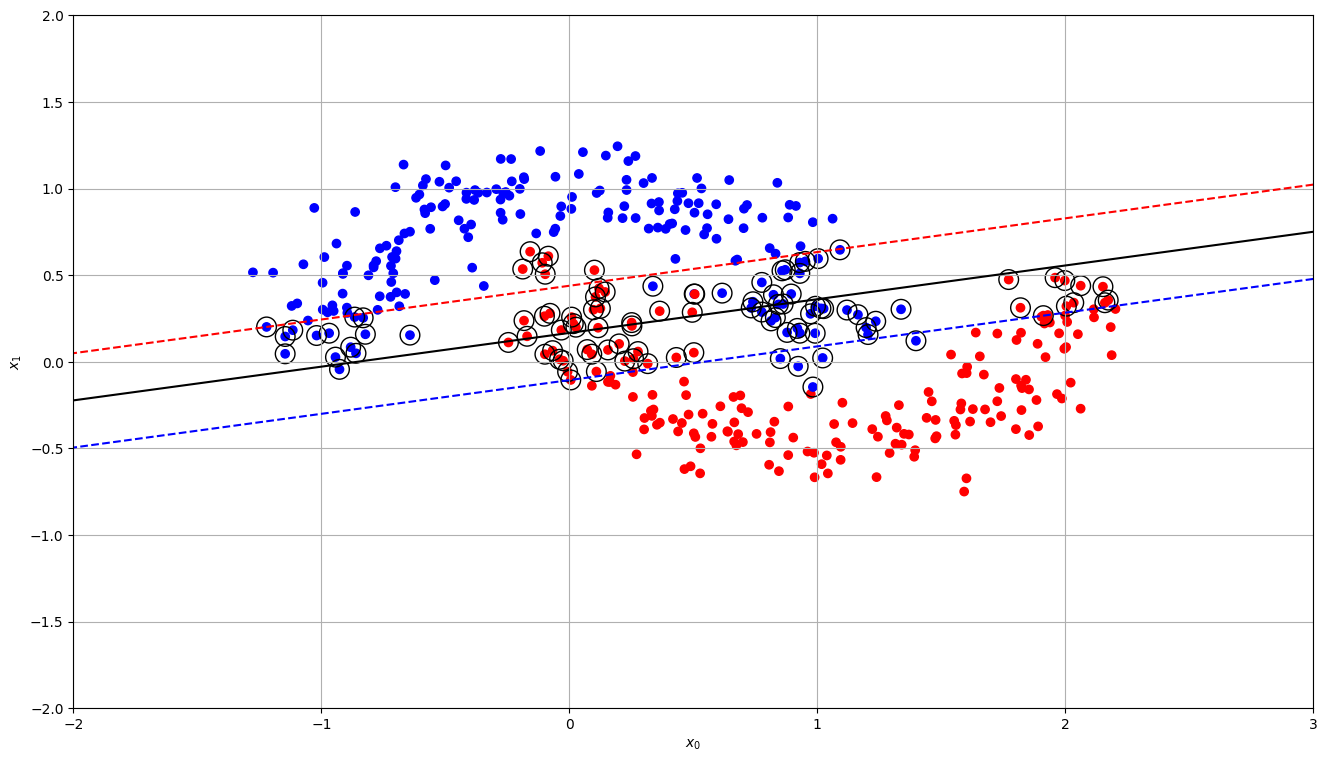

In [7]:
tuneAndTest(SVC(kernel="linear"),{"C": uniform(0,20)})

best hyper-parameter value:  {'C': 7.826529617851785, 'coef0': 3, 'degree': 3, 'gamma': 0.6095896671142067}
confusion matrix: [[42  3]
 [ 0 55]]
recall: 1.0
precision: 0.9482758620689655


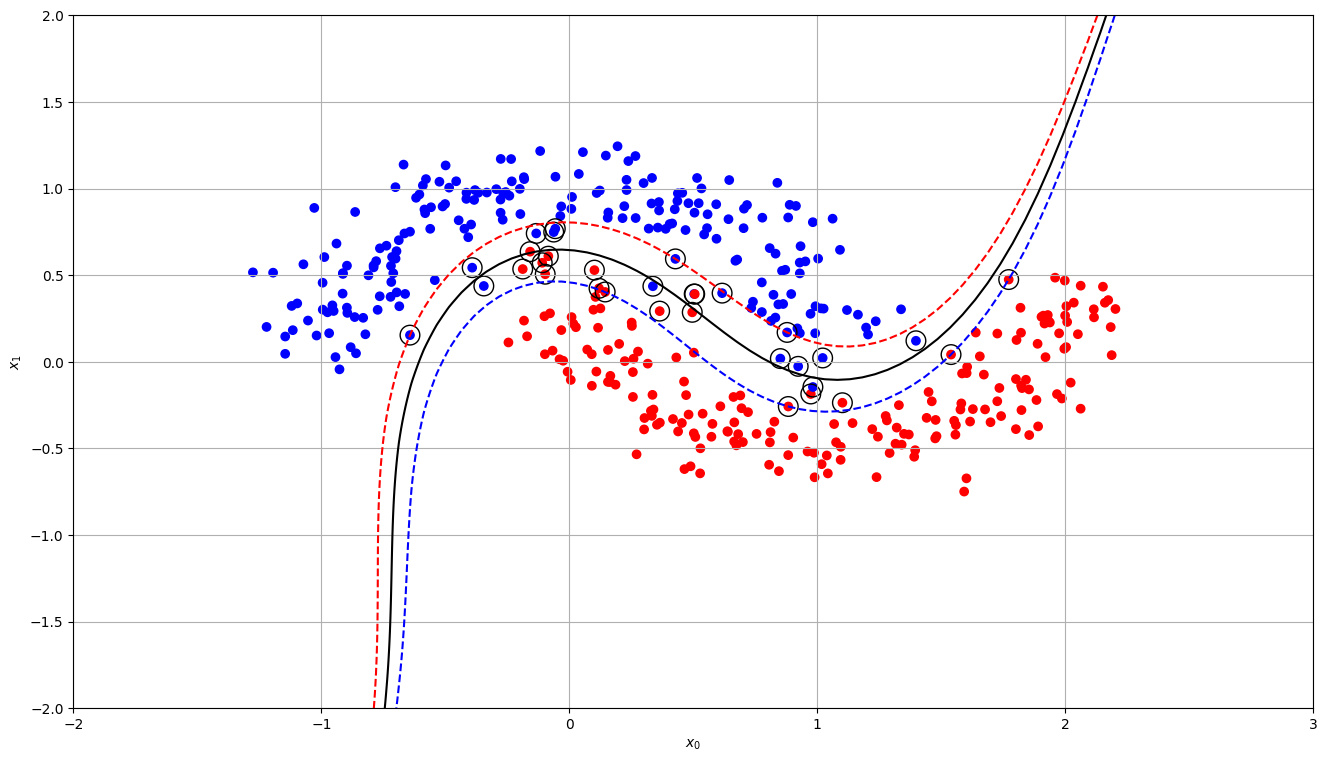

In [8]:
tuneAndTest(SVC(kernel="poly"),{"coef0":randint(low=0, high=5),"C": uniform(0,20),"degree": randint(low=2, high=5), "gamma":uniform(0, 1)})

best hyper-parameter value:  {'C': 10.527990485942908, 'gamma': 0.6238122128846867}
confusion matrix: [[42  3]
 [ 0 55]]
recall: 1.0
precision: 0.9482758620689655


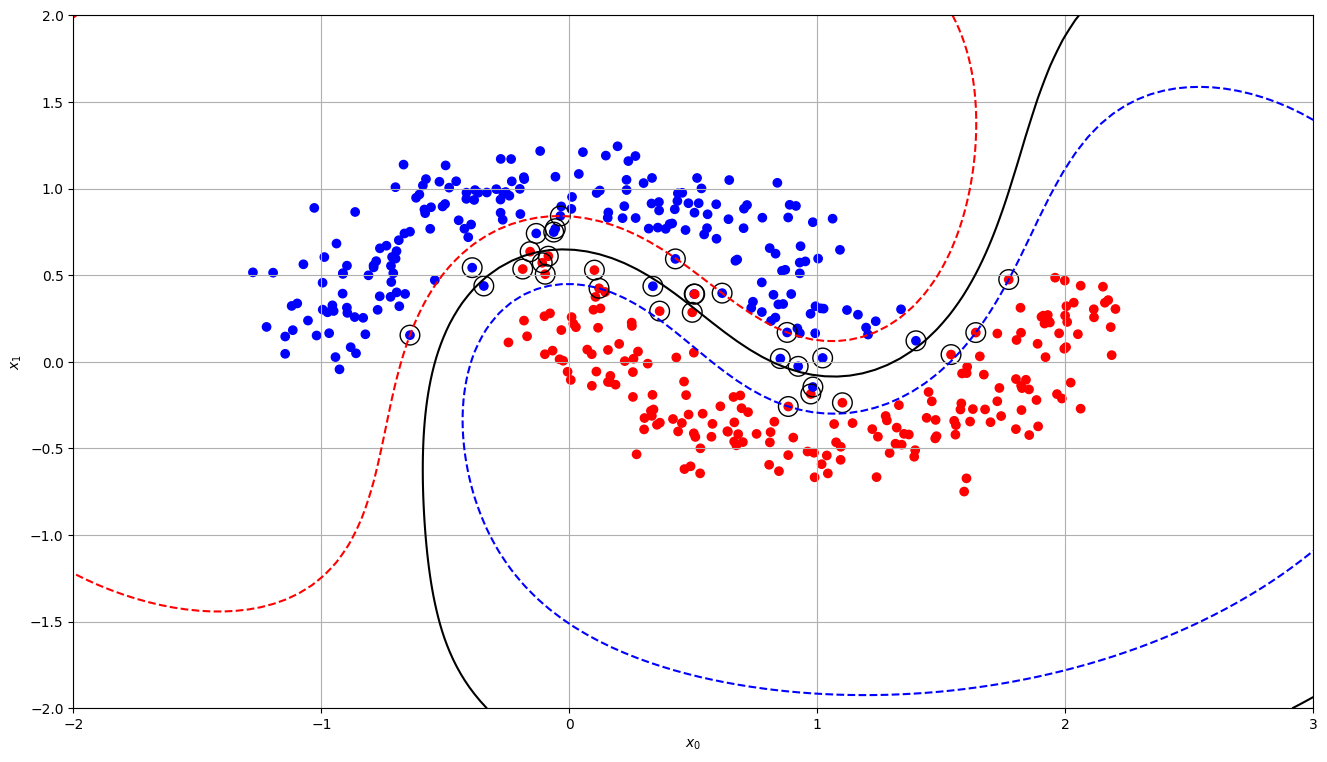

In [9]:
tuneAndTest(SVC(kernel="rbf"),{"C": uniform(0,20), "gamma":uniform(0, 1)})

## 3. IMPLEMENT YOUR OWN NON-LINEAR SVM (60 pts)
Now that you see how the standard library SVM perform on the dataset, you will attempt to implement your own version of SVM. To help you, a template of SVM has been created including the quadratic optimization. Essensially, you will get the optimized value of $\alpha$ for free.

The provided code is extensively documented in comments, so that you may write code compatible with it. DO NOT edit the provided code.

Many of these tasks are made much easier by a working knowledge of numpy. If you have something you want to do, but are unsure how to do it in Python, consult the numpy documentation here: https://numpy.org/doc/1.17/reference/index.html. If you haven't built a Python class before, it may be worth scanning this tutorial: https://www.datacamp.com/community/tutorials/python-oop-tutorial.

In [10]:
# Use the information from the lecture slides to formulate the SVM Kernels.
# To help you get started, the Linear Kernel (simply just a dot product) has been provided to you.
# These kernel functions will be called in the SVM class
# Linear Kernel
def linear_kernel(u, v):
    return np.dot(u, v)

# Polynomial Kernel (of degree up to and including p)
def polynomial_kernel(u, v, p=3):
    return np.dot(u,v)**p

# Gaussian RBF Kernel
def rbf_kernel(u, v, gamma=0.1):
    # Note that gamma is provided, not sigma; see the slides for the relationship between gamma and sigma
    return np.exp(-gamma*np.linalg.norm(u-v)**2)

In [54]:
class MySVM(BaseEstimator, ClassifierMixin):
    """The Implementation of the SVM class"""

    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel  # Kernel function, can be called within the class
        self.C = C
        if self.C is not None:
            self.C = float(self.C)

    def fit(self, X, y=None):
        """
        Train SVM based on the training set
        Parameters
        ----------
        X: feature matrix shape(m_samples, n_features)
        y: label vector shape(m_samples, )
        """
        self.X = X
        self.y = y
        m_samples, n_features = X.shape

        # Compute the kernel matrix
        K = np.zeros((m_samples, m_samples))
        for i in range(m_samples):
            for j in range(m_samples):
                K[i, j] = self.kernel(X[i], X[j])

        # Define Quadratic Programming parameters
        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(np.ones(m_samples) * -1)
        A = cvxopt.matrix(y, (1, m_samples), 'd')
        b = cvxopt.matrix(0.0)

        # TODO: If self.C is None, set G and h for a hard margin SVM. Else, define them for soft margin SVM.
        if self.C is None:
            G = cvxopt.matrix(-np.eye(m_samples))
            h = cvxopt.matrix(np.zeros(m_samples))
        else:
            G = cvxopt.matrix(np.vstack((-np.eye(m_samples), np.eye(m_samples))))
            h = cvxopt.matrix(np.hstack((np.zeros(m_samples), np.ones(m_samples) * self.C)))

        # Solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        a = np.ravel(solution['x'])

        # TODO: Identify support vectors and store them in self.support_vectors_
        sv = a > 1e-3
        self.a = a[sv]
        self.support_vectors_ = X[sv]
        self.sv_y = y[sv]


        if self.kernel == linear_kernel:
            ay = (a * y)[:, np.newaxis]
            self.w = np.dot(ay.T, X).T
        else:
            self.w = None

        # TODO: Compute the intercept b based on support vectors.
        self.b = np.mean(y - np.sum(a * y * K, axis=0))

    def decision_function(self, X):
        """The decision function is essentially w^T . x + b"""
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            # TODO: Implement the kernel trick to predict label for non-linear SVM
            y_predict = np.zeros(X.shape[0])
            for i in range(X.shape[0]):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.support_vectors_):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self, X):
        """Predicts -1,+1 based on the sign of the decision function"""
        return np.sign(self.decision_function(X))


---
## 4. COMPARE YOUR IMPLEMENTATION TO THE STANDARD LIBRARY (20 pts)
Now that you have implemented your own SVM class, let's use it! Create 3 instances of your SVM class, each with a difference kernel (Linear, Polynomial, and RBF kernel), then train and test its performance in the Moon dataset as above. Use the same hyperparameters found to be best for the standard library implementations, and report the same metrics (confusion matrix, recall, and precision). You can use the plot_svm() function to visualize your SVM with decision boundary, margin, and support vectors on the dataset, and should plot each of the three instances of your class, to compare these plots with the standard library models' plots.

Based on the number above, compare your SVM implementation with the standard library version. How did your SVM perform in comparison? Is there any major differences between the algorithms? If your performance is significantly worse, is there a different set of hyperparameters which better fits your model? Finally, reflect on your experience implementing a learning algorithm for this assignment.

In [29]:
import matplotlib.pyplot as plt

def printResult(model):
    """Displays confusion matrix, recall, precision, and plots SVM boundaries."""
    # TODO: Use model.predict() to generate predictions for the test set
    y_hat = model.predict(X_test)

    # TODO: Print out evaluation metrics (confusion matrix, recall, precision) for the model
    print("confusion matrix:", confusion_matrix(y_test, y_hat))
    print("recall:",recall_score(y_test, y_hat))
    print("precision:",precision_score(y_test, y_hat))

    # TODO: Use plot_svm to visualize the decision boundary, support vectors, and margins
    plot_svm(model, X_train, y_train)


def comp(mysvm, lib):
    """Compares the custom SVM with the standard library SVM implementation."""
    # TODO: Fit both the custom SVM and library SVC model on the training data
    mysvm.fit(X_train, y_train)
    lib.fit(X_train, y_train)

    print("Custom SVM Implementation:")
    print(mysvm)
    # TODO: Call printResult to display the results of the custom SVM
    printResult(mysvm)

    print("Standard Library Implementation:")
    # TODO: Call printResult to display the results of the library SVC model
    printResult(lib)


In [50]:
custom_linear_svm = MySVM(kernel=linear_kernel, C=8.1537)

     pcost       dcost       gap    pres   dres
 0: -5.7855e+02 -1.7691e+04  4e+04  7e-01  3e-14
 1: -4.5535e+02 -4.4529e+03  4e+03  2e-02  3e-14
 2: -6.0289e+02 -1.4379e+03  9e+02  3e-03  2e-14
 3: -7.3065e+02 -1.0600e+03  3e+02  1e-03  3e-14
 4: -7.8022e+02 -9.5918e+02  2e+02  5e-04  3e-14
 5: -8.0913e+02 -9.0561e+02  1e+02  2e-04  3e-14
 6: -8.2120e+02 -8.8377e+02  6e+01  1e-04  3e-14
 7: -8.3144e+02 -8.6567e+02  3e+01  6e-05  4e-14
 8: -8.3841e+02 -8.5497e+02  2e+01  2e-05  3e-14
 9: -8.4240e+02 -8.4859e+02  6e+00  1e-06  4e-14
10: -8.4391e+02 -8.4674e+02  3e+00  6e-07  3e-14
11: -8.4458e+02 -8.4600e+02  1e+00  2e-08  4e-14
12: -8.4504e+02 -8.4550e+02  5e-01  6e-09  4e-14
13: -8.4525e+02 -8.4526e+02  2e-02  2e-10  5e-14
14: -8.4526e+02 -8.4526e+02  2e-03  1e-11  4e-14
15: -8.4526e+02 -8.4526e+02  2e-05  1e-13  4e-14
Optimal solution found.
Custom SVM Implementation:
MySVM(C=8.1537)
confusion matrix: [[34 11]
 [ 5 50]]
recall: 0.9090909090909091
precision: 0.819672131147541


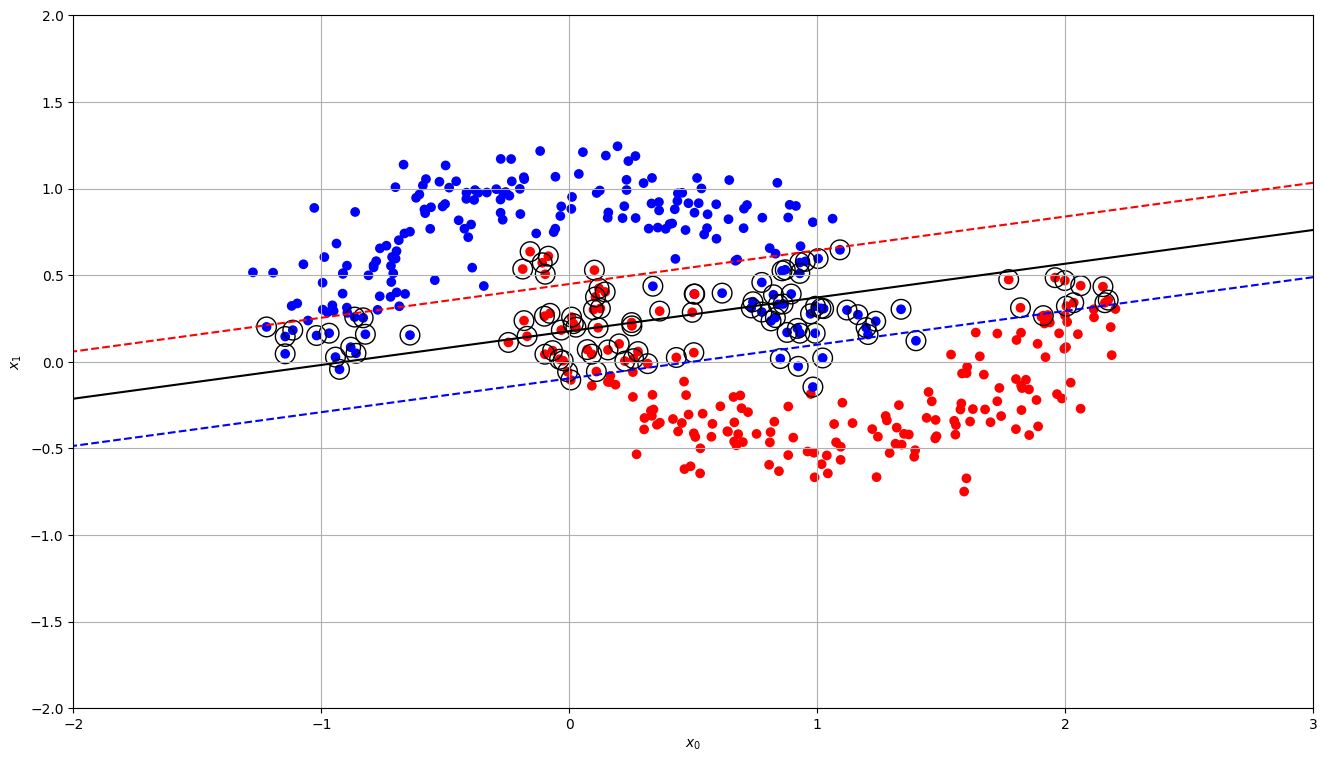

Standard Library Implementation:
confusion matrix: [[34 11]
 [ 5 50]]
recall: 0.9090909090909091
precision: 0.819672131147541


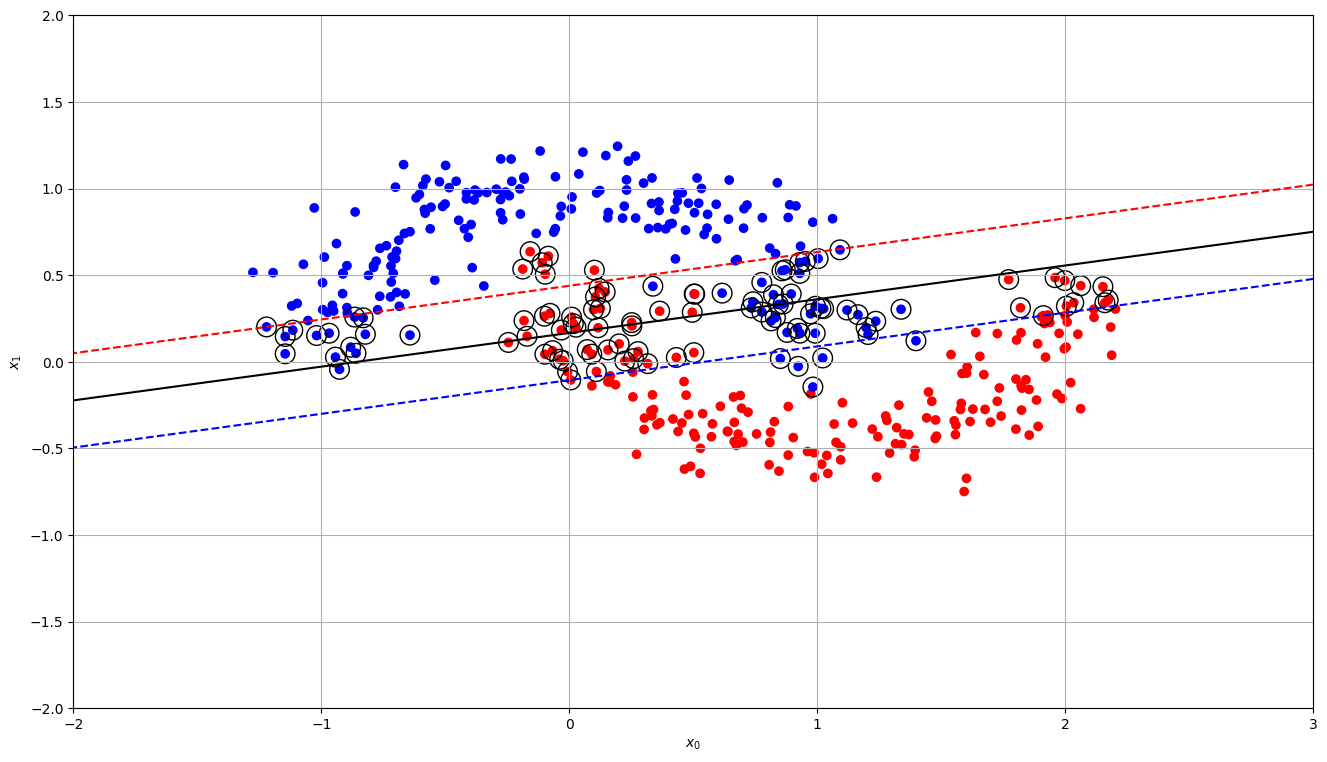

In [51]:
comp(custom_linear_svm, SVC(kernel="linear", C=8.1537))

In [55]:
custom_poly_svm = MySVM(kernel=lambda u, v: polynomial_kernel(u, v, p=3), C=0.5)

     pcost       dcost       gap    pres   dres
 0: -1.3363e+02 -4.3967e+02  3e+03  5e+00  4e-14
 1: -7.0747e+01 -3.4267e+02  7e+02  7e-01  3e-14
 2: -5.4831e+01 -1.7586e+02  2e+02  2e-01  2e-14
 3: -4.9700e+01 -8.8543e+01  6e+01  5e-02  8e-15
 4: -5.0467e+01 -6.4546e+01  2e+01  2e-02  9e-15
 5: -5.0975e+01 -5.9211e+01  1e+01  7e-03  7e-15
 6: -5.1974e+01 -5.5270e+01  4e+00  2e-03  7e-15
 7: -5.2322e+01 -5.3989e+01  2e+00  8e-04  7e-15
 8: -5.2758e+01 -5.2981e+01  2e-01  1e-05  7e-15
 9: -5.2829e+01 -5.2898e+01  7e-02  8e-07  7e-15
10: -5.2859e+01 -5.2866e+01  7e-03  8e-08  8e-15
11: -5.2862e+01 -5.2863e+01  5e-04  3e-09  8e-15
12: -5.2862e+01 -5.2862e+01  1e-05  3e-12  7e-15
Optimal solution found.
Custom SVM Implementation:
MySVM(C=0.5, kernel=<function <lambda> at 0x787586bda170>)
confusion matrix: [[42  3]
 [18 37]]
recall: 0.6727272727272727
precision: 0.925


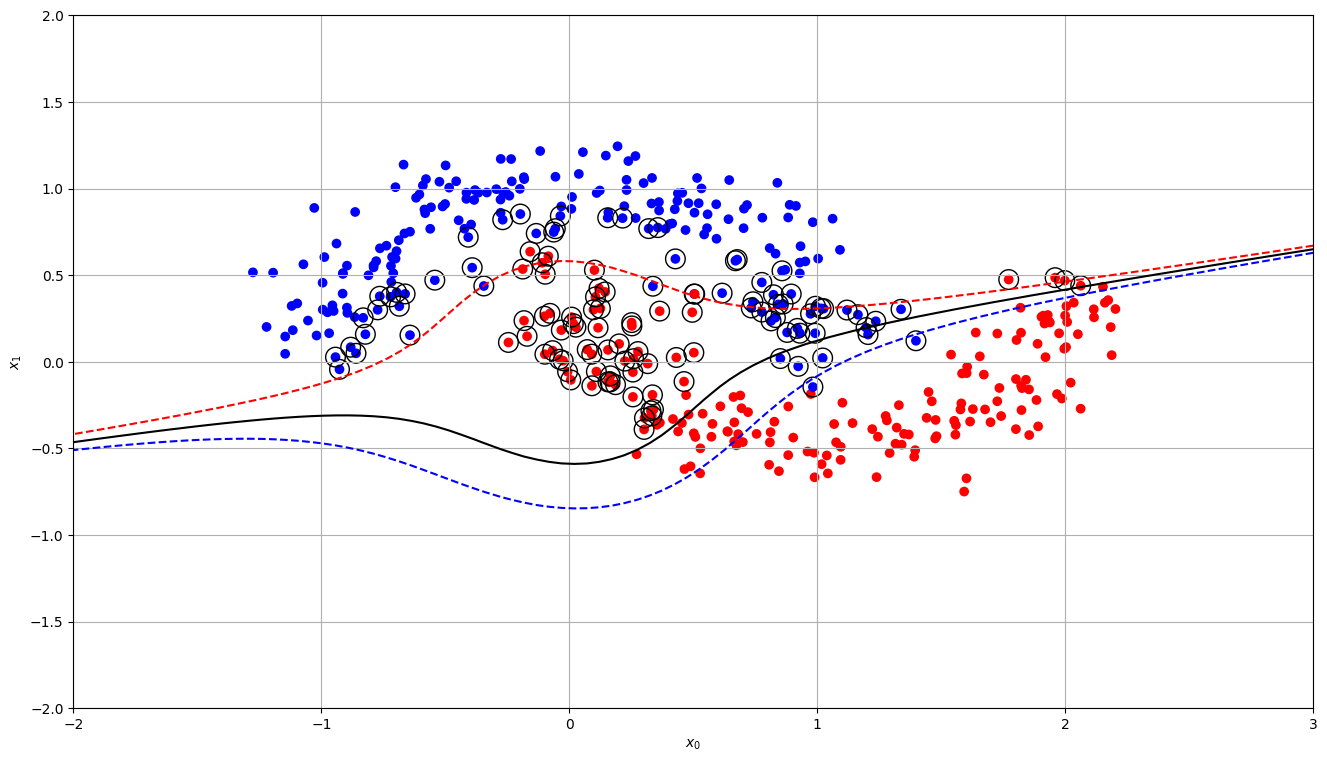

Standard Library Implementation:
confusion matrix: [[35 10]
 [ 1 54]]
recall: 0.9818181818181818
precision: 0.84375


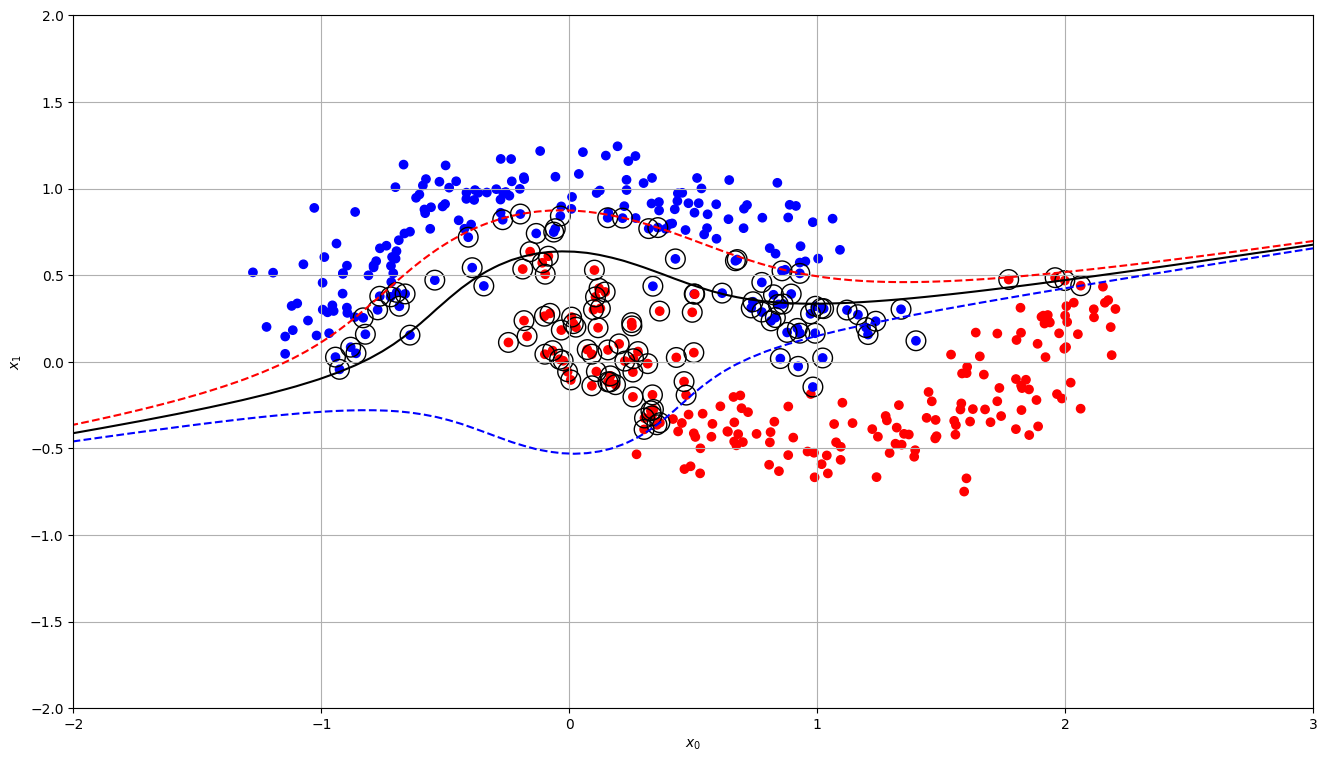

In [59]:
comp(custom_poly_svm, SVC(kernel="poly", C=0.5, degree=3))

In [57]:
custom_rbf_svm = MySVM(kernel=lambda u, v: rbf_kernel(u, v, gamma=0.1), C=1.5)

     pcost       dcost       gap    pres   dres
 0: -1.5950e+02 -1.2618e+03  4e+03  1e+00  6e-15
 1: -1.1747e+02 -6.0008e+02  5e+02  3e-02  5e-15
 2: -1.4445e+02 -2.4133e+02  1e+02  6e-03  4e-15
 3: -1.6544e+02 -1.9423e+02  3e+01  1e-03  5e-15
 4: -1.7088e+02 -1.8409e+02  1e+01  5e-04  5e-15
 5: -1.7350e+02 -1.8015e+02  7e+00  1e-04  6e-15
 6: -1.7540e+02 -1.7735e+02  2e+00  1e-05  7e-15
 7: -1.7614e+02 -1.7642e+02  3e-01  2e-06  6e-15
 8: -1.7625e+02 -1.7630e+02  5e-02  3e-07  7e-15
 9: -1.7627e+02 -1.7627e+02  7e-04  3e-09  7e-15
10: -1.7627e+02 -1.7627e+02  7e-06  3e-11  7e-15
Optimal solution found.
Custom SVM Implementation:
MySVM(C=1.5, kernel=<function <lambda> at 0x787586c59120>)
confusion matrix: [[34 11]
 [ 6 49]]
recall: 0.8909090909090909
precision: 0.8166666666666667


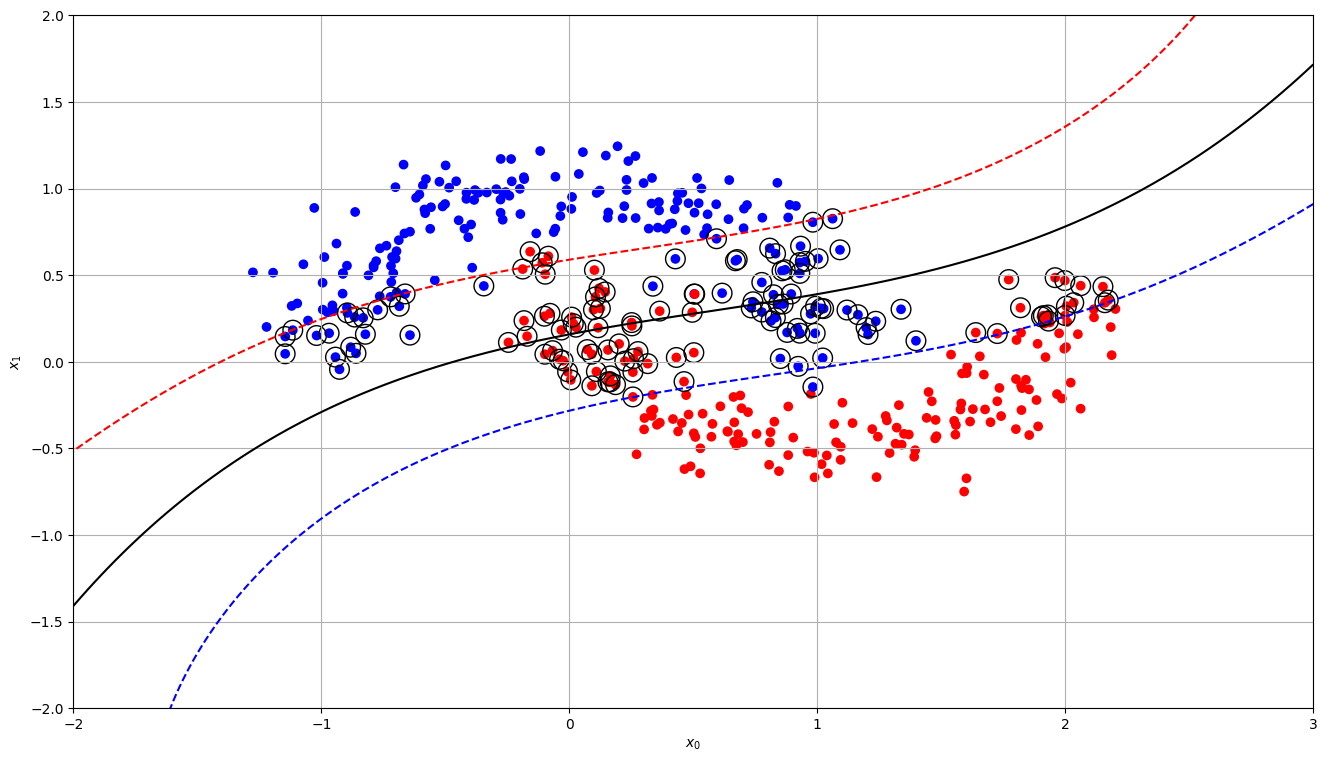

Standard Library Implementation:
confusion matrix: [[34 11]
 [ 6 49]]
recall: 0.8909090909090909
precision: 0.8166666666666667


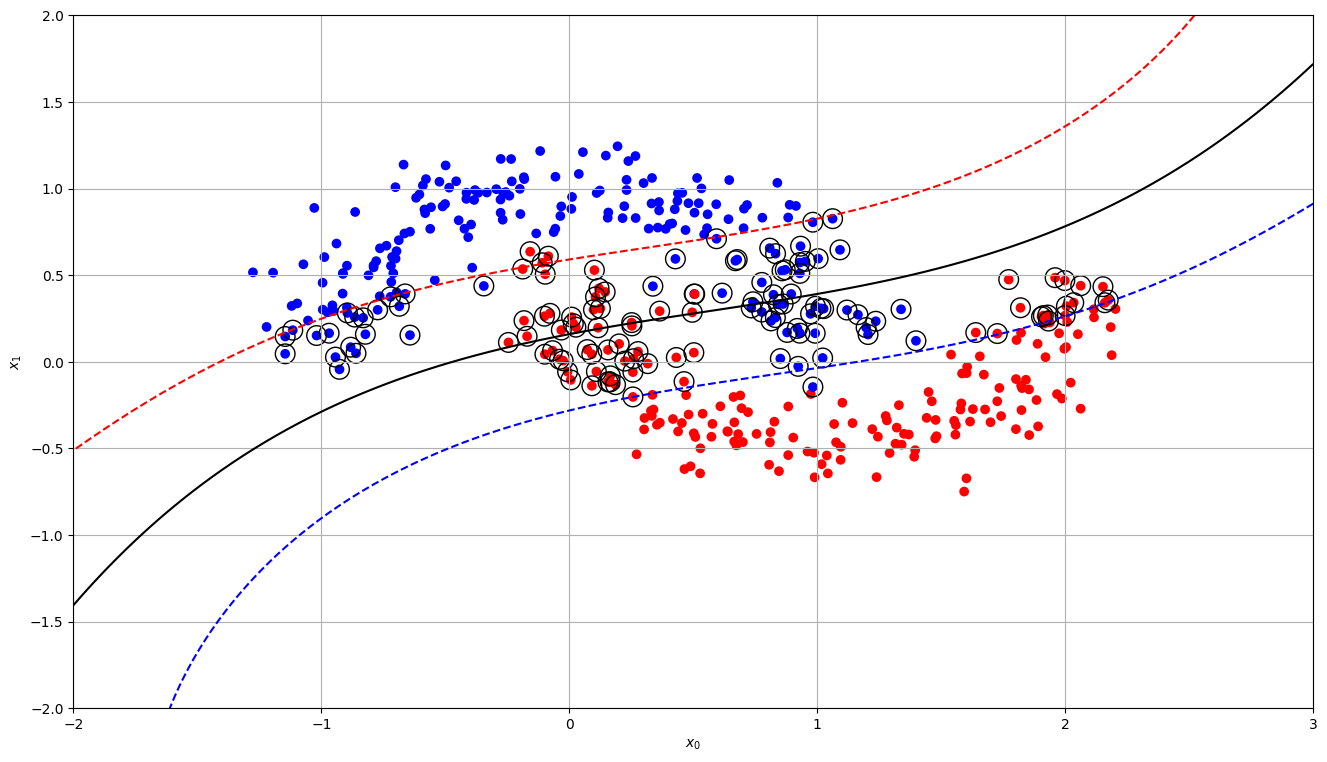

In [58]:
comp(custom_rbf_svm, SVC(kernel="rbf", C=1.5, gamma=0.1))